In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys

def check_tensorflow_version():
    """Check TensorFlow version and compatibility"""
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Keras version: {tf.keras.__version__}")
    print(f"Python version: {sys.version}")

    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(f"GPU available: {len(gpus) > 0}")
    if gpus:
        for gpu in gpus:
            print(f"  - {gpu}")

def convert_model_for_compatibility(input_path, output_path):
    """Convert model to be compatible with current TensorFlow version"""

    print(f"Converting model: {input_path} -> {output_path}")

    # Strategy 1: Load and re-save with current TF version
    try:
        print("Attempting to load and re-save model...")

        # Try loading with minimal settings
        model = tf.keras.models.load_model(input_path, compile=False)

        # Re-compile the model with current TF version
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Save in current format
        model.save(output_path)
        print(f"✓ Model successfully converted and saved to {output_path}")
        return True

    except Exception as e:
        print(f"Conversion failed: {e}")
        return False

def extract_and_rebuild_mobilenet(input_path, output_path, num_classes=7):
    """Extract weights and rebuild MobileNet architecture"""

    print("Attempting to rebuild MobileNet architecture...")

    try:
        # Create a new MobileNet model
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet'  # Start with ImageNet weights
        )

        # Add custom classification head
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print("✓ New MobileNet model created")

        # Try to load weights from original model if possible
        try:
            old_model = tf.keras.models.load_model(input_path, compile=False)

            # Try to transfer compatible weights
            for i, layer in enumerate(model.layers):
                if i < len(old_model.layers):
                    try:
                        old_weights = old_model.layers[i].get_weights()
                        if old_weights and len(old_weights) == len(layer.get_weights()):
                            layer.set_weights(old_weights)
                            print(f"  Transferred weights for layer {i}: {layer.name}")
                    except:
                        print(f"  Could not transfer weights for layer {i}: {layer.name}")

        except Exception as e:
            print(f"Could not load original weights: {e}")
            print("Using ImageNet weights only")

        # Save the new model
        model.save(output_path)
        print(f"✓ Rebuilt model saved to {output_path}")
        return True

    except Exception as e:
        print(f"Model rebuilding failed: {e}")
        return False

def create_demo_model(output_path, num_classes=7):
    """Create a simple demo model for testing"""

    print("Creating demo model...")

    try:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(224, 224, 3)),

            # Simple CNN architecture
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

        # Compile the model
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Save the model
        model.save(output_path)
        print(f"✓ Demo model saved to {output_path}")

        # Print model summary
        print("\nModel Summary:")
        model.summary()

        return True

    except Exception as e:
        print(f"Demo model creation failed: {e}")
        return False

def test_model(model_path):
    """Test if the model can be loaded and used for prediction"""

    print(f"Testing model: {model_path}")

    try:
        # Load model
        model = tf.keras.models.load_model(model_path)
        print("✓ Model loaded successfully")

        # Create dummy input
        dummy_input = np.random.random((1, 224, 224, 3)).astype(np.float32)

        # Make prediction
        prediction = model.predict(dummy_input, verbose=0)
        print(f"✓ Prediction successful: shape={prediction.shape}")
        print(f"  Sample prediction: {prediction[0][:3]}... (showing first 3 values)")

        return True

    except Exception as e:
        print(f"Model test failed: {e}")
        return False

def main():
    """Main function to handle model conversion"""

    print("="*60)
    print("TENSORFLOW MODEL COMPATIBILITY CONVERTER")
    print("="*60)

    # Check TensorFlow version
    check_tensorflow_version()
    print()

    input_model = "emotion_mobilenet_model.h5"

    if not os.path.exists(input_model):
        print(f"❌ Original model '{input_model}' not found!")
        print("Creating a demo model for testing...")

        demo_model_path = "emotion_demo_model.h5"
        if create_demo_model(demo_model_path):
            test_model(demo_model_path)
        return

    print(f"Found original model: {input_model}")

    # Try different conversion strategies
    strategies = [
        ("emotion_mobilenet_converted.h5", convert_model_for_compatibility),
        ("emotion_mobilenet_rebuilt.h5", lambda inp, out: extract_and_rebuild_mobilenet(inp, out)),
    ]

    for output_path, convert_func in strategies:
        print(f"\n{'='*40}")
        print(f"Trying strategy: {convert_func.__name__}")
        print(f"{'='*40}")

        if convert_func(input_model, output_path):
            print(f"Testing converted model...")
            if test_model(output_path):
                print(f"✅ SUCCESS! Use this model: {output_path}")
                break
        else:
            print(f"Strategy failed, trying next...")
    else:
        print("\n❌ All conversion strategies failed!")
        print("Creating demo model as fallback...")
        demo_model_path = "emotion_demo_model.h5"
        if create_demo_model(demo_model_path):
            test_model(demo_model_path)

    print(f"\n{'='*60}")
    print("CONVERSION PROCESS COMPLETED")
    print(f"{'='*60}")

if __name__ == "__main__":
    main()

TENSORFLOW MODEL COMPATIBILITY CONVERTER
TensorFlow version: 2.18.0
Keras version: 3.8.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
GPU available: False

Found original model: emotion_mobilenet_model.h5

Trying strategy: convert_model_for_compatibility
Converting model: emotion_mobilenet_model.h5 -> emotion_mobilenet_converted.h5
Attempting to load and re-save model...
Conversion failed: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': N

✓ New MobileNet model created
Could not load original weights: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}
Using ImageNet weights only
✓ Rebuilt model saved to emotion_mobilenet_rebuilt.h5
Testing converted model...
Testing model: emotion_mobilenet_rebuilt.h5


✓ Model loaded successfully
✓ Prediction successful: shape=(1, 7)
  Sample prediction: [0.575472   0.00129823 0.08361536]... (showing first 3 values)
✅ SUCCESS! Use this model: emotion_mobilenet_rebuilt.h5

CONVERSION PROCESS COMPLETED


📂 Please upload your `.h5` model file now
✅ Loading model: emotion_mobilenet_rebuilt.h5


📸 Capturing image... (click 'Take Snapshot' when prompted)


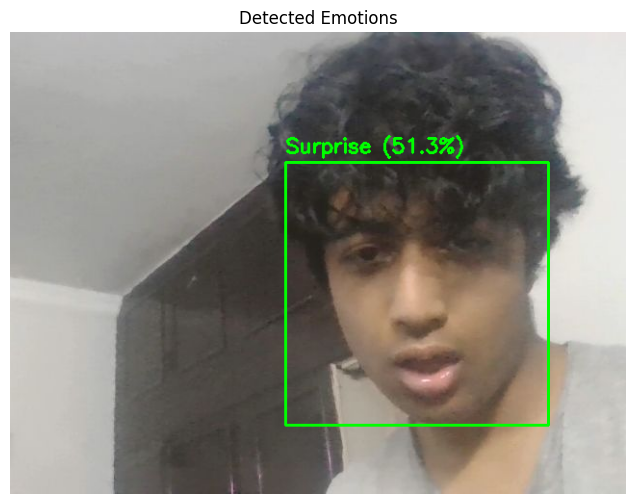

In [ ]:

# ---------------------------------------------------
# IMPORTS
# ---------------------------------------------------
import cv2
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from io import BytesIO
from base64 import b64decode
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab.output import eval_js

# ---------------------------------------------------
# CAPTURE IMAGE FROM WEBCAM (via JavaScript)
# ---------------------------------------------------
def capture_image_from_webcam():
    js_code = '''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Take Snapshot';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', 0.8);
    }
    takePhoto();
    '''
    data = eval_js(js_code)
    _, encoded = data.split(",", 1)
    img_bytes = b64decode(encoded)
    img = Image.open(BytesIO(img_bytes))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# ---------------------------------------------------
# LOAD MODEL
# ---------------------------------------------------
def load_rebuilt_model():
    candidates = [
        "emotion_mobilenet_converted.h5",
        "emotion_mobilenet_rebuilt.h5",
        "emotion_demo_model.h5",
        "emotion_mobilenet_model.h5"
    ]
    for path in candidates:
        if os.path.exists(path):
            try:
                print(f"✅ Loading model: {path}")
                model = tf.keras.models.load_model(path)
                return model, path
            except Exception as e:
                print(f"❌ Failed to load {path}: {e}")
    print("❌ No model found!")
    return None, None

# ---------------------------------------------------
# PREPROCESS FACE IMAGE
# ---------------------------------------------------
def preprocess_face_for_model(face_roi, img_size=224):
    face_resized = cv2.resize(face_roi, (img_size, img_size))
    face_normalized = face_resized.astype(np.float32) / 255.0
    return np.expand_dims(face_normalized, axis=0)

# ---------------------------------------------------
# SETUP FOR DETECTION
# ---------------------------------------------------
def setup_emotion_detection():
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    model, path = load_rebuilt_model()
    if model is None:
        return None, None, None
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    return model, emotion_labels, face_cascade

# ---------------------------------------------------
# MAIN DETECTION FUNCTION (single-frame in Colab)
# ---------------------------------------------------
def colab_emotion_detection():
    model, emotion_labels, face_cascade = setup_emotion_detection()
    if model is None:
        return

    print("📸 Capturing image... (click 'Take Snapshot' when prompted)")
    frame = capture_image_from_webcam()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_roi = frame[y:y + h, x:x + w]
        processed = preprocess_face_for_model(face_roi)
        predictions = model.predict(processed, verbose=0)[0]
        emotion_idx = np.argmax(predictions)
        confidence = predictions[emotion_idx] * 100
        emotion = emotion_labels[emotion_idx]
        label = f"{emotion} ({confidence:.1f}%)"
        color = (0, 255, 0)

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Show the result
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    plt.axis("off")
    plt.title("Detected Emotions")
    plt.show()

# ---------------------------------------------------
# UPLOAD MODEL FILE FIRST
# ---------------------------------------------------
from google.colab import files
print("📂 Please upload your `.h5` model file now")
uploaded =  '/content/emotion_mobilenet_model.h5'

# ---------------------------------------------------
# RUN EMOTION DETECTION
# ---------------------------------------------------
colab_emotion_detection()
